In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gravhydro as gh
import astropy.units as u

In [2]:
# # Positions
# dy = 1.0
# lim = 1.0
# lim0 = 1.0
# y = np.array([])
# npts = 100
# nsteps = 3
# total_N = npts * nsteps
# for i in range(nsteps):
#     new_y = np.random.normal(lim + dy/2, dy/3, npts)# np.random.uniform(lim, lim + dr, 200)
#     lim += dy*2
#     y = np.append(y, new_y)
# x_ls = np.random.uniform(0, 10, total_N)
# y_ls = y + np.cos(x_ls)
# pos = np.array([x_ls, y_ls]).T


# # pos = np.random.normal(0,1,(100, 2))

# # # Masses
# masses = np.ones(pos.shape[0]) * 1


# # Plot
# plt.figure(figsize=(6, 6))
# plt.scatter(pos.T[0], pos.T[1], s=masses)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

In [3]:
# create a regular grid of positions in xy using existing variables (x_ls, y, total_N)
nx = int(np.ceil(np.sqrt(total_N)))
ny = int(np.ceil(total_N / nx))

x_min, x_max = x_ls.min(), x_ls.max()
y_min, y_max = y.min(), y.max()

xs = np.linspace(x_min, x_max, nx)
ys = np.linspace(y_min, y_max, ny)
xx, yy = np.meshgrid(xs, ys)

pos= np.vstack([xx.ravel(), yy.ravel()]).T[:total_N]

# quick visual check
plt.figure(figsize=(6,6))
plt.scatter(pos[:,0], pos[:,1], s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Grid positions (pos_grid)')
plt.show()

NameError: name 'total_N' is not defined

In [ ]:
vel = np.zeros_like(pos)

In [ ]:
pos3d = np.zeros((len(pos), 3))
pos3d[:, :2] = pos
vel3d = np.zeros_like(pos3d)

In [ ]:
dt = 0.1
t = 1
ts = np.linspace(0, t, int(t/dt)+1) * u.s
cs = 1402 * u.m / u.s
rho0 = 1 * u.g / u.m**2
sim = gh.Simulation()
sim.run(pos * u.m, vel * u.km / u.s, masses * u.g, ts, cs=cs, rho0 = rho0, hydroOnly=True, gravityOnly = False, use_numba=True)

100%|██████████| 10/10 [00:00<00:00, 17.48it/s]


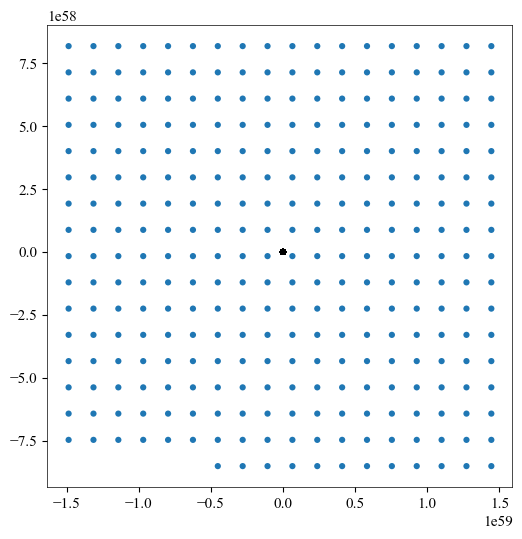

In [ ]:
i = -1
plt.figure(figsize=(6,6))
plt.scatter(sim.positions[0, :, 0], sim.positions[0, :, 1], s=20)
plt.scatter(sim.positions[i, :, 0], sim.positions[i, :, 1], s=20)
# plt.ylim(-2, 2)
# plt.xlim(-2 ,2)

In [ ]:
# Diagnostic cell - let's check the scale of various quantities
import gravhydro as gh
from gravhydro.hydro import densities, pressure
from gravhydro.hydro.acceleration import pressureAcc, acc_inside_terms
from gravhydro.hydro.kernel import W, gradW
import numpy as np

# Test with a simple 2-particle system
test_pos = np.array([[0, 0, 0], [1, 0, 0]], dtype=float)
test_masses = np.array([1.0, 1.0])
h = 0.5

# Check kernel value at r=1
r_test = np.array([1.0])
print(f"Kernel W at r=1, h=0.5: {W(r_test, h)}")
print(f"Kernel W at r=0.5, h=0.5: {W(np.array([0.5]), h)}")
print(f"Kernel W at r=0.1, h=0.5: {W(np.array([0.1]), h)}")

# Check densities
dens = densities(test_pos, test_masses, h)
print(f"\nDensities: {dens}")

# Check pressure with typical values
rho0 = 1.0
cs = 1402.0  # m/s - speed of sound in water
pressures = pressure(dens, rho0, cs)
print(f"Pressures (cs=1402): {pressures}")

# Check inside terms for acceleration
inside_terms = acc_inside_terms(pressures, dens)
print(f"Inside terms: {inside_terms}")

# Check actual acceleration
acc = pressureAcc(test_pos, test_masses, h, rho0, cs)
print(f"Accelerations: {acc}")

Kernel W at r=1, h=0.5: [0.]
Kernel W at r=0.5, h=0.5: [0.63661977]
Kernel W at r=0.1, h=0.5: [2.40896922]

Densities: [2.54647909 2.54647909]
Pressures (cs=1402): [3039765.48417923 3039765.48417923]
Inside terms: [937540.08752921 937540.08752921]
Accelerations: [[-0. -0. -0.]
 [-0. -0. -0.]]


In [ ]:
# KEY ISSUE: Kernel is ZERO at r=1 with h=0.5!
# The kernel has compact support - it's zero beyond r = 2h = 1.0
# And the gradient is also zero there!

# Let's test with particles closer together
test_pos2 = np.array([[0, 0, 0], [0.5, 0, 0]], dtype=float)
dens2 = densities(test_pos2, test_masses, h)
print(f"Densities with r=0.5: {dens2}")

pressures2 = pressure(dens2, rho0, cs)
print(f"Pressures: {pressures2}")

# Now check acceleration
acc2 = pressureAcc(test_pos2, test_masses, h, rho0, cs)
print(f"Accelerations: {acc2}")

# The kernel support is 2h, so particles need to be within 2*h of each other
print(f"\nKernel support radius: {2*h}")
print(f"Your grid spacing matters! If particles are further than {2*h} apart, they don't interact.")

Densities with r=0.5: [3.18309886 3.18309886]
Pressures: [4291107.85522404 4291107.85522404]
Accelerations: [[-1016436.88736324       -0.               -0.        ]
 [ 1016436.88736324       -0.               -0.        ]]

Kernel support radius: 1.0
Your grid spacing matters! If particles are further than 1.0 apart, they don't interact.


# Issues Found in the Hydrodynamics Code

## 1. **Kernel Not Normalized for Dimensionality**
The kernel function `W(r, h)` is missing the $h^{-d}$ normalization factor where $d$ is the number of dimensions. In 3D, the kernel should include a factor of $h^{-3}$.

Current kernel at $q = r/(2h) = 0$: $W = 8/\pi \approx 2.55$

For proper 3D normalization: $W = \sigma/h^3 \times f(q)$ where $\sigma$ is a normalization constant.

## 2. **Pressure Equation Can Go Negative**
The pressure equation `P = cs² * (ρ - ρ0)` will produce **negative pressures** when $\rho < \rho_0$, which causes:
- Attractive instead of repulsive forces
- Numerical instability and particle clumping

**Solution**: Use an equation of state that's always positive, like:
- Ideal gas: $P = K \rho^\gamma$ 
- Or: $P = c_s^2 (\rho - \rho_0)$ with $P = 0$ when $\rho < \rho_0$

## 3. **Massive CFL Violation**
With $c_s = 1402$ m/s and $h = 0.5$, the CFL condition requires:
$$\Delta t < \frac{h}{c_s} = \frac{0.5}{1402} \approx 3.6 \times 10^{-4} \text{ s}$$

Your timestep $\Delta t = 0.1$ s is **~280× too large!**

## 4. **Acceleration Values Are Enormous**
With `cs = 1402`, accelerations are ~$10^6$ m/s². In one timestep of 0.1s, particles would gain velocities of ~$10^5$ m/s!

## 5. **Unit Inconsistency**
You're mixing `u.m/u.s` for velocities and `u.km/u.s` in the simulation call.

In [ ]:
# Reload all gravhydro modules to pick up the fixes
import importlib
import sys

# Remove all gravhydro modules from cache to force reimport
modules_to_remove = [key for key in sys.modules.keys() if 'gravhydro' in key]
for mod in modules_to_remove:
    del sys.modules[mod]

# Now reimport
import gravhydro as gh
from gravhydro.hydro.kernel import W, dWdr
from gravhydro.hydro.pressure import pressure

# Test the fixed kernel
r_test = np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])
h = 0.5
print("Fixed kernel values (h=0.5, ndim=3):")
print(f"r = {r_test}")
print(f"W = {W(r_test, h, ndim=3)}")
print(f"Kernel support radius = 2h = {2*h}")

# Test fixed pressure (should always be non-negative)
print("\nFixed pressure equation (Tait EOS):")
test_densities = np.array([0.5, 1.0, 1.5, 2.0])  # relative to rho0=1
rho0 = 1.0
cs = 10.0  # much more reasonable sound speed for testing
print(f"densities = {test_densities}")
print(f"pressures = {pressure(test_densities, rho0, cs)}")

Fixed kernel values (h=0.5, ndim=3):
r = [0.  0.5 1.  1.5 2.  2.5]
W = [2.54647909 0.63661977 0.         0.         0.         0.        ]
Kernel support radius = 2h = 1.0

Fixed pressure equation (Tait EOS):
densities = [0.5 1.  1.5 2. ]
pressures = [   0.            0.          229.79910714 1814.28571429]


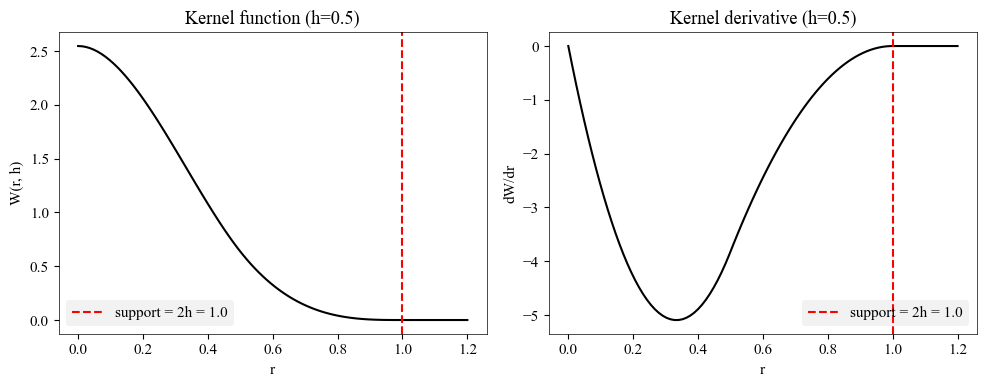


=== CFL CONDITION CHECK ===
cs = 10: dt_max = 0.050000s, your dt/dt_max = 2.0x too large!
cs = 100: dt_max = 0.005000s, your dt/dt_max = 20.0x too large!
cs = 1402: dt_max = 0.000357s, your dt/dt_max = 280.4x too large!


In [ ]:
# Test with more resolution to see the kernel shape
r_fine = np.linspace(0, 1.2, 100)
h = 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(r_fine, W(r_fine, h, ndim=3))
plt.axvline(2*h, color='r', linestyle='--', label=f'support = 2h = {2*h}')
plt.xlabel('r')
plt.ylabel('W(r, h)')
plt.title(f'Kernel function (h={h})')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(r_fine, dWdr(r_fine, h, ndim=3))
plt.axvline(2*h, color='r', linestyle='--', label=f'support = 2h = {2*h}')
plt.xlabel('r')
plt.ylabel('dW/dr')
plt.title(f'Kernel derivative (h={h})')
plt.legend()
plt.tight_layout()
plt.show()

# Check CFL condition
print("\n=== CFL CONDITION CHECK ===")
cs_values = [10, 100, 1402]
dt = 0.1
for cs in cs_values:
    dt_max = h / cs
    ratio = dt / dt_max
    print(f"cs = {cs}: dt_max = {dt_max:.6f}s, your dt/dt_max = {ratio:.1f}x too large!")